In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Embedding, LSTM, Dense, Flatten, Reshape, Attention, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_df = pd.read_csv("/content/VR_Train_Emb.csv")
train_df.head()

,Unnamed: 0.1,Unnamed: 0,question,answer,image_id,image,label,split,pooler_output,LHS,BERT_pooler_output,BERT_LHS
0,0,0,are regions of the brain infarcted?,yes,0,/content/train/kaggle/working/train/0.png,78,train,[[-4.15634423e-01 -2.18633011e-01 1.23488329e...,[[[ 0.20274048 0.34934664 -0.5113254 ... -0....,[[ 0.07978443 -0.13336562 0.08196832 -0.14794...,[[-0.03380692 0.08464462 -0.02945923 ... -0.1...
1,1,1,are the lungs normal appearing?,no,1,/content/train/kaggle/working/train/1.png,109,train,[[ 4.91200536e-02 1.26657277e-01 -3.05416938e...,[[[-0.148142 0.10915223 -1.0637746 ... 0....,[[ 6.41742945e-02 -1.35044396e-01 7.82183185e...,[[-5.0863441e-02 1.0242079e-01 -1.9856434e-02...
2,3,3,is the lesion causing significant brainstem he...,no,3,/content/train/kaggle/working/train/3.png,109,train,[[-0.6961587 0.0832852 0.21249478 -0.44286...,[[[-0.08065961 -0.1205781 -0.8257754 ... 0....,[[ 8.42936710e-02 -1.37623131e-01 8.45395550e...,[[-0.032382 0.09276641 -0.02214786 ... -0.1...
3,5,5,is this image in the transverse plane?,yes,9,/content/train/kaggle/working/train/9.png,78,train,[[-0.26736712 -0.71014696 -0.4011913 -0.21945...,[[[-0.82390666 0.31531572 -0.8019041 ... -0....,[[ 0.07401221 -0.1456637 0.08481682 -0.14187...,[[-4.7084399e-02 8.9686424e-02 -5.1976148e-02...
4,6,6,are there any pulmonary findings?,no,10,/content/train/kaggle/working/train/10.png,109,train,[[-7.64926821e-02 1.63867891e-01 -2.69446522e...,[[[-0.00340338 0.4043334 -0.69638467 ... 0....,[[ 0.0722234 -0.13484631 0.08574356 -0.14604...,[[-0.04342871 0.10207354 -0.05432218 ... -0.0...


In [ ]:
test_df = pd.read_csv("/content/VR_Test_Emb.csv")
test_df.head()

,Unnamed: 0.1,Unnamed: 0,question,answer,image_id,image,label,split,pooler_output,LHS,BERT_pooler_output,BERT_LHS
0,1321,0,is there evidence of an aortic aneurysm?,yes,0,/content/test/kaggle/working/test/0.png,78,test,[[-3.79437715e-01 2.92319596e-01 -1.52506530e...,[[[-1.2255638e-01 1.3018084e-01 -1.2608231e+0...,[[ 0.08150899 -0.12743214 0.08919282 -0.13318...,[[-0.05657627 0.0998497 -0.05125942 ... -0.1...
1,1322,1,is there airspace consolidation on the left side?,yes,1,/content/test/kaggle/working/test/1.png,78,test,[[ 4.91200536e-02 1.26657277e-01 -3.05416938e...,[[[-0.148142 0.10915223 -1.0637746 ... 0....,[[ 7.06100613e-02 -1.39744788e-01 1.04695573e...,[[-0.05259708 0.06921858 -0.03462698 ... -0.0...
2,1323,2,is there any intraparenchymal abnormalities in...,no,2,/content/test/kaggle/working/test/2.png,109,test,[[ 1.96340397e-01 2.57583350e-01 -1.43540740e...,[[[-0.4797985 0.29681936 -0.75277907 ... -0....,[[ 6.61141053e-02 -1.39728904e-01 8.89760628e...,[[-0.02523502 0.0941537 -0.04854548 ... -0.0...
3,1325,4,are the kidneys present in this image?,no,5,/content/test/kaggle/working/test/5.png,109,test,[[-6.33725107e-01 -4.10758793e-01 3.44804138e...,[[[-5.0024915e-01 -3.4376976e-01 -7.1118832e-0...,[[ 7.92723224e-02 -1.24781601e-01 7.81859756e...,[[-0.06934284 0.08773336 -0.04365717 ... -0.0...
4,1329,8,is the liver visible in the image?,no,9,/content/test/kaggle/working/test/9.png,109,test,[[-8.38306189e-01 9.52408835e-02 5.12672663e...,[[[-1.3804451 0.509425 0.6566619 ... -0....,[[ 8.04461762e-02 -1.25662312e-01 8.01614895e...,[[-0.04960352 0.08340733 -0.04727279 ... -0.0...


# Get Image Embeddings

In [ ]:
def str_to_numpy(text):
  data_string = text.strip('[]').split()
  data_array = np.array([float(val) for val in data_string])
  data_array = data_array.reshape(1, -1)
  return data_array

In [ ]:
train_image_emb = [str_to_numpy(train_df['pooler_output'][i]) for i in range(train_df.shape[0])]
train_image_emb = np.array(train_image_emb)
train_image_emb = train_image_emb.reshape(-1, 768)
train_image_emb.shape

(940, 768)

In [ ]:
test_image_emb = [str_to_numpy(test_df['pooler_output'][i]) for i in range(test_df.shape[0])]
test_image_emb = np.array(test_image_emb)
test_image_emb = test_image_emb.reshape(-1, 768)
test_image_emb.shape

(251, 768)

## Get Text Embeddings

In [ ]:
train_text_emb = [str_to_numpy(train_df['BERT_pooler_output'][i]) for i in range(train_df.shape[0])]
train_text_emb = np.array(train_text_emb)
train_text_emb = train_text_emb.reshape(-1, 768)
train_text_emb.shape

(940, 768)

In [ ]:
test_text_emb = [str_to_numpy(test_df['BERT_pooler_output'][i]) for i in range(test_df.shape[0])]
test_text_emb = np.array(test_text_emb)
test_text_emb = test_text_emb.reshape(-1, 768)
test_text_emb.shape

(251, 768)

In [ ]:
# Encode answer labels
label_encoder = LabelEncoder()
encoded_answers_train = label_encoder.fit_transform(train_df['answer'])
encoded_answers_test = label_encoder.fit_transform(test_df['answer'])

In [ ]:
np.unique(encoded_answers_train)

array([0, 1])

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
ytrain = to_categorical(encoded_answers_train)
ytest = to_categorical(encoded_answers_test)
ytrain[30]

array([0., 1.], dtype=float32)

In [ ]:
# Define the model
image_input = Input(shape=(768,))
text_input = Input(shape=(768,))

In [ ]:
from tensorflow.keras.layers import Attention,Multiply,Lambda

# Multi-modal attention mechanism using Lambda layer
concatenated = Lambda(lambda x: x[0] * x[1])([image_input, text_input])

# Continue with the dense layers for classification

In [ ]:
# Concatenate the image and text embeddings
#concatenated = Concatenate()([image_input, text_input])

In [ ]:
concatenated.shape

TensorShape([None, 768])

In [ ]:
# Add some dense layers for classification
dense1 = Dense(384, activation='relu')(concatenated)
#dense2 = Dense(128, activation='relu')(dense1)
output = Dense(2, activation='softmax')(dense1)

model = Model(inputs=[image_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.2,
    patience = 3,
    min_lr = 1e-4
)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


callbacks = [checkpoint, reduce_lr, early_stopping]

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 384)                  295296    ['lambda[0][0]']          

In [ ]:
history = model.fit(
    [train_image_emb, train_text_emb],
    ytrain,
    validation_data=([test_image_emb, test_text_emb], ytest),
    batch_size = 32,
    shuffle = True,
    epochs=100,
    callbacks = callbacks
)

Epoch 1/100
30/30 [==============================] - 2s 14ms/step - loss: 0.6729 - accuracy: 0.5734 - val_loss: 0.7128 - val_accuracy: 0.5657 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 0.6386 - accuracy: 0.6436 - val_loss: 0.6908 - val_accuracy: 0.5339 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 0s 7ms/step - loss: 0.6156 - accuracy: 0.6660 - val_loss: 0.6866 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5958 - accuracy: 0.6926 - val_loss: 0.6864 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.5836 - accuracy: 0.6851 - val_loss: 0.7623 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5579 - accuracy: 0.7117 - val_loss: 0.6865 - val_accuracy: 0.5896 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.

In [ ]:
average_training_accuracy = np.mean(history.history['accuracy'])
print(f'Average training accuracy: {average_training_accuracy}')

Average training accuracy: 0.7069148932184491


In [ ]:

average_validation_accuracy = np.mean(history.history['val_accuracy'])
print(f'Average validation accuracy: {average_validation_accuracy}')

Average validation accuracy: 0.5887877132211413


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


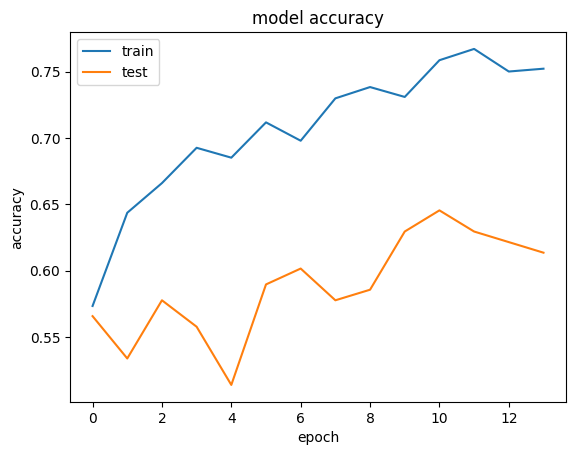

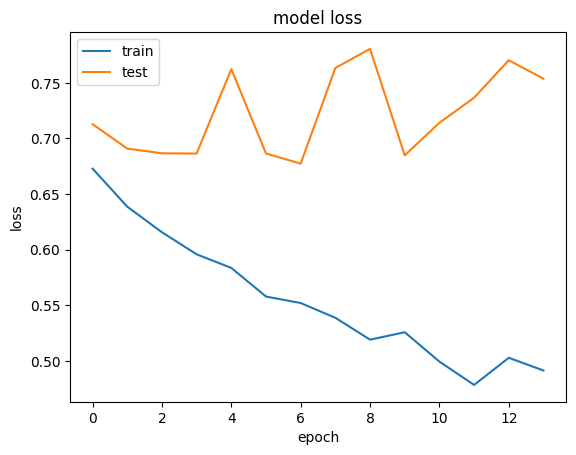

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img_size = 224

In [ ]:
image_sample = test_image_emb
text_sample = test_text_emb

# Now, you can make predictions
predictions = model.predict([image_sample, text_sample])

8/8 [==============================] - 0s 2ms/step


In [ ]:
predicted_indices = np.argmax(predictions, axis=1)
y_true = np.argmax(ytest, axis=1)

# Use the LabelEncoder to convert indices back to original class labels
predicted_labels = label_encoder.inverse_transform(predicted_indices)
predicted_labels

array(['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no',
       'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes',
       'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes',
       'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no',
       'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes',
       'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no',
       'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no',
       'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no',

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_indices))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       133
           1       0.65      0.54      0.59       118

    accuracy                           0.65       251
   macro avg       0.65      0.64      0.64       251
weighted avg       0.65      0.65      0.64       251



ROC AUC Score =  0.639607493309545


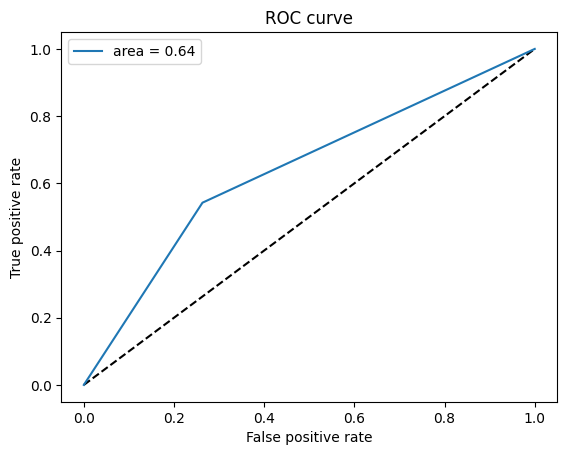

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
print('ROC AUC Score = ',roc_auc_score(y_true, predicted_indices))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, predicted_indices)
auc_keras = auc(fpr_keras, tpr_keras)

"""**Let's plot our ROC Curve**"""

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()